In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pickle
import json

from shapely import wkt

from joblib import Parallel, delayed
import multiprocessing

import scipy.stats as stats
from scipy.spatial import distance
from sklearn.preprocessing import OrdinalEncoder
from easydict import EasyDict as edict
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

import powerlaw

In [2]:
# import sys
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.utils import setup_seed, load_config

In [3]:
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [4]:
def _apply_parallel(ls, func, n=-1, **kwargs):
    """parallel apply for spending up."""
    length = len(ls)
    cpunum = multiprocessing.cpu_count()
    if length < cpunum:
        spnum = length
    if n < 0:
        spnum = cpunum + n + 1
    else:
        spnum = n or 1

    return Parallel(n_jobs=n, verbose=0)(delayed(func)(seq, **kwargs) for seq in ls)

# Read 

## Read sequences

In [283]:
# file_name = ".\\runs\mobis_diffseq_evaluate_v2_b\seed101_solverstep10.json"
file_dir = [    
    # ".\\data\\validation\\mobis_na_ls_150_4_200.json",
    # ".\\data\\validation\\mobis_na_150_4_200_clamp.json",
    # ".\\data\\validation\\mobis_na_layer4_150_4_200.json",
    # ".\\data\\validation\\mobis_na_half_150_4_200_clamp.json",
    # ".\\data\\validation\\mobis_na_diffseq_150_1_200.json",
    # ".\\data\\validation\\mobis_na_diffseq_v2_150_1_200.json",
    # ".\\data\\validation\\mobis_na_diffseq_4_150_4_200.json",
    # ".\\data\\validation\\mobis_na_diffseq_layer4_150_1_200.json",
    # ".\\data\\validation\\mobis_na_diffseq_xy_150_1_200.json",
    # ".\\data\\validation\\mobis_na_diffseq_poi_150_1_200.json",
    # ".\\data\\validation\\mobis_na_diffseq_all_150_1_200.json",
    # ".\\data\\validation\\mobis_na_diffseq_all_layer4_150_1_200.json",

    # ".\\data\\validation\\na_all_layer2_cond_13_150_1_20.json",
    # ".\\data\\validation\\na_all_layer2_cond_13_150_1_200.json",
    # ".\\data\\validation\\na_all_layer2_cond_13_150_1_200_clamp.json",
    # ".\\data\\validation\\na_all_layer2_cond_14_150_1_200.json",
    # ".\\data\\validation\\na_all_layer2_cond_14_150_1_200_clamp.json",
    # ".\\data\\validation\\na_all_layer4_cond_13_150_1_200.json",
    # ".\\data\\validation\\na_all_layer4_cond_13_150_1_200_clamp.json",
    # ".\\data\\validation\\na_all_layer6_cond_13_150_1_200.json",
    # ".\\data\\validation\\na_all_layer6_cond_13_150_1_200_clamp.json",


    # ".\\data\\validation\\na_multi_layer2_cond_13_150_1_200.json",
    # ".\\data\\validation\\na_dur_layer2_cond_13_150_1_200.json",

    # ".\\data\\validation\\na_multi_default_13_150_1_200.json",

    # ".\\data\\validation\\na_base_13_150_1_200.json",
    # ".\\data\\validation\\na_base_smallLoss_13_150_1_200.json",
    # ".\\data\\validation\\na_smallLoss_13_150_1_200.json",

    # ".\\data\\validation\\na_13_150_1_20.json",
    # ".\\data\\validation\\na_13_150_1_200.json",
    ".\\data\\validation\\na_base_13_150_1_200_copy.json",
    ".\\data\\validation\\na_base_13_150_1_200.json",
    

    # ".\\data\\validation\\na_dur_loss_layer2_cond_13_150_1_20.json",
    # ".\\data\\validation\\na_dur_loss_layer2_cond_13_150_1_200.json",
    
]

predict_ls = []
true_ls = []
src_ls = []

for i, file in enumerate(file_dir):
    predict_curr = []
    with open(file, "r") as f_reader:
        for row in f_reader:
            content = json.loads(row)

            if i == 0:
                src_ls.append((np.array(content["source"])))
    
                target_arr = np.array(content["target"])
                try:
                    target_arr = target_arr[:np.where(target_arr == 0)[0][0]]
                except IndexError:
                    target_arr = target_arr
                true_ls.append(target_arr)

            if len(content["recover"]) >= 50:
                predict_curr.append(np.array(content["recover"][:50]).squeeze())
            else:
                print(len(content["recover"]))
    predict_ls.append(predict_curr)


In [284]:
len(predict_ls), len(predict_ls[0]), len(true_ls), len(src_ls)

(2, 36285, 36285, 36285)

In [285]:
np.mean([len(seq) for seq in src_ls]), np.mean([len(seq) for seq in true_ls])\
, np.max([len(seq) for seq in true_ls]), np.min([len(seq) for seq in true_ls])

(138.37412153782554, 47.75587708419457, 50, 2)

In [286]:
diff_file_name = [name.split("\\")[-1].split(".")[0] for name in file_dir]
# diff_file_name = ["Diffusion (Ours)"]
# diff_file_name = ["Base", "Base + xy + POI"]
diff_file_name 

['na_base_13_150_1_200_copy', 'na_base_13_150_1_200']

In [287]:
clean_predict_ls = []
for ls in predict_ls:
    clean_data = []
    for x in ls:
        clean_data.append(np.array([14881 if item>14881 else item for item in x]))

    clean_predict_ls.append(clean_data)

In [288]:
for i in range(len(predict_ls)):
    print(np.max([np.max(x) for x in predict_ls[i]]), np.max([np.max(x) for x in clean_predict_ls[i]]))

14906 14881
14870 14870


In [289]:
predict_ls = clean_predict_ls

## Read all locations

In [291]:
# initialization
config = load_config("./config/diff.yml")
config = edict(config)

In [292]:
all_locs = pd.read_csv(os.path.join("data", "s2_loc_visited_level10_13.csv"), index_col="id")
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

In [293]:
enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
    all_locs["loc_id"].values.reshape(-1, 1)
)
all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

In [294]:
all_locs

,loc_id,level,geometry,freq,area
id,,,,,
0,1,10,POINT (2824875.045 1159436.528),1,POLYGON ((10.405097146225662 46.50637570678295...
1,2,13,POINT (2822437.857 1167754.527),38,POLYGON ((10.347820052132302 46.61871685680636...
2,3,13,POINT (2815796.126 1167304.569),1,POLYGON ((10.260953592346382 46.61685460820135...
3,4,13,POINT (2816020.303 1168362.492),1,POLYGON ((10.264376293749178 46.62629143145975...
4,5,13,POINT (2818994.419 1169160.037),1,POLYGON ((10.303565033130825 46.63249007077394...
...,...,...,...,...,...
14876,14877,13,POINT (2767507.842 1213073.682),1,"POLYGON ((9.64763962539829 47.042237657717536,..."
14877,14878,13,POINT (2768419.907 1212986.551),1,"POLYGON ((9.65960383635977 47.04122268391671, ..."
14878,14879,13,POINT (2769332.126 1212899.406),1,"POLYGON ((9.671569607102107 47.04020629289218,..."


## Read Markov generation

In [295]:
file_name = ".\\data\\validation\\mobis_markov_generation.json"

markov_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)


        markov_ls.append(np.array(content["recover"]).squeeze())

len(markov_ls)

36320

## Read MHSA generation

In [296]:
file_name = ".\\data\\validation\\mobis_mhsa_k500_p099.json"

ar_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)


        ar_ls.append(np.array(content["recover"]).squeeze())

clean_ls = []
for x in ar_ls:
    clean_ls.append(np.array([14881 if item>14881 else item for item in x]))
print(np.max([np.max(x) for x in ar_ls]), np.max([np.max(x) for x in clean_ls]))

ar_ls = clean_ls
len(ar_ls)

14866 14866


36320

## Read GAN generation

In [297]:
file_name = ".\\runs\\temp\\generated_samples_99.pk"
gan_locs = pickle.load(open(file_name, "rb"))["locs"]

gan_ls = [locs[:-1] for locs in gan_locs]

clean_ls = []
for x in gan_ls:
    clean_ls.append(np.array([14881 if item>14881 else item for item in x]))
print(np.max([np.max(x) for x in gan_ls]), np.max([np.max(x) for x in clean_ls]))

gan_ls = clean_ls
len(gan_ls)

14936 14881


10240

## Read EPR generation

In [298]:
file_name = ".\\data\\validation\\mobis_epr_generation.json"

epr_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)
        epr_ls.append(np.array(content["recover"]).squeeze())

        # if len(np.array(content["recover"]).squeeze()) != 50:
        #     print("error")

len(epr_ls)

36320

In [299]:
file_name = ".\\data\\validation\\mobis_container_generation.json"

container_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)
        container_ls.append(np.array(content["recover"]).squeeze())


len(container_ls)



36320

# Jump length

In [300]:
def get_jumplength(seq, geo_x, geo_y):
    locs = seq - 1 # padding

    return np.array([np.sqrt((geo_x[locs][i] - geo_x[locs][i - 1])**2 + (geo_y[locs][i] - geo_y[locs][i - 1])**2) for i in range(1, len(locs))])

geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

In [301]:
predict_jp = [np.hstack(_apply_parallel(predict, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y)) for predict in predict_ls]

predict_jp = [predict[predict>1] for predict in predict_jp]

In [302]:
true_jp = np.hstack(_apply_parallel(true_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
source_jp = np.hstack(_apply_parallel(src_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))

true_jp = true_jp[true_jp>1]
source_jp = source_jp[source_jp>1]

In [303]:
markov_jp = np.hstack(_apply_parallel(markov_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
markov_jp = markov_jp[markov_jp>1]

ar_jp = np.hstack(_apply_parallel(ar_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
ar_jp = ar_jp[ar_jp>1]

gan_jp = np.hstack(_apply_parallel(gan_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
gan_jp = gan_jp[gan_jp>1]

epr_jp = np.hstack(_apply_parallel(epr_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
epr_jp = epr_jp[epr_jp>1]

container_jp = np.hstack(_apply_parallel(container_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
container_jp = container_jp[container_jp>1]

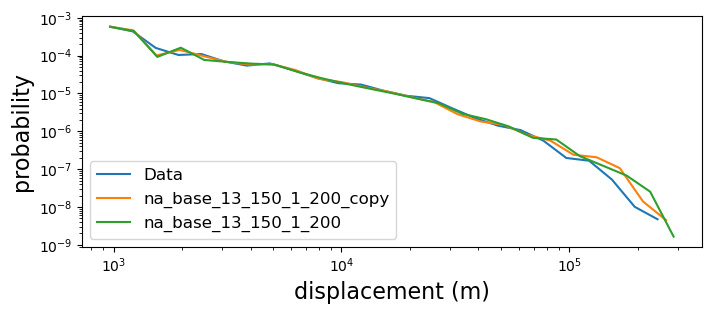

In [305]:
plt.figure(figsize=(8, 3))

# plotting
powerlaw.plot_pdf(true_jp, label="Data")
# powerlaw.plot_pdf(source_jp, label="source")
for predict, label in zip(predict_jp, diff_file_name):
    powerlaw.plot_pdf(predict, label=label)

# powerlaw.plot_pdf(ar_jp, label="MHSA decode (Ours)")
# powerlaw.plot_pdf(markov_jp, label="Markov", alpha=0.5)
# powerlaw.plot_pdf(gan_jp, label="MovSim", alpha=0.5)
# powerlaw.plot_pdf(epr_jp, label="EPR", alpha=0.5)
# powerlaw.plot_pdf(container_jp, label="Container", alpha=1)

# fit power law
# fit = powerlaw.Fit(true_jp, xmin=1)
# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 12})
plt.xlabel("displacement (m)", fontsize=16)
plt.ylabel("probability", fontsize=16)

# plt.savefig(r'.\metrics\figures\jump.png', bbox_inches='tight', dpi=600)

plt.show()

In [1446]:
predict = np.log(predict_jp[0])
true = np.log(true_jp)
source = np.log(source_jp)

min = predict.min()
max = predict.max()

In [1447]:
pred_dist_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_dist_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_dist_p, _ =  np.histogram(source, bins=1000, range=(min, max))

pred_true_js = distance.jensenshannon(pred_dist_p, true_dist_p)
source_true_js = distance.jensenshannon(source_dist_p, true_dist_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.210	 Source and True: 0.078


In [359]:
markov = np.log(markov_jp)
ar = np.log(ar_jp)
gan = np.log(gan_jp)
epr =  np.log(epr_jp)

In [360]:
markov_dist_p, _ =  np.histogram(markov, bins=1000, range=(min, max))
markov_true_js = distance.jensenshannon(markov_dist_p, true_dist_p)

ar_dist_p, _ =  np.histogram(ar, bins=1000, range=(min, max))
ar_true_js = distance.jensenshannon(ar_dist_p, true_dist_p)

gan_dist_p, _ =  np.histogram(gan, bins=1000, range=(min, max))
gan_true_js = distance.jensenshannon(gan_dist_p, true_dist_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

epr_dist_p, _ =  np.histogram(epr, bins=1000, range=(min, max))
epr_true_js = distance.jensenshannon(epr_dist_p, true_dist_p)

print(f"EPR and True: {epr_true_js:.3f}")

Markov and True: 0.570	 AR and True: 0.481	 GAN and True: 0.488
EPR and True: 0.533


# Visit frequency - dataset location

In [306]:
def get_loc_p(ls):
    visits = np.zeros(shape=(len(all_locs)), dtype=float)
    for seq in ls:
        locs = seq - 1 # padding

        visits[locs] += 1
    visits.sort()
    visits = visits[::-1]
    return visits

In [307]:
predict_p = [get_loc_p(predict) for predict in predict_ls]

predict_p

[array([6692., 4702., 2767., ...,    0.,    0.,    0.]),
 array([6942., 4449., 2730., ...,    0.,    0.,    0.])]

In [308]:
predict = [ p[p>0] / p.sum() for p in predict_p ]

In [309]:
true_p = get_loc_p(true_ls)
source_p = get_loc_p(src_ls)

true_p, source_p

(array([6131., 5098., 3286., ...,    0.,    0.,    0.]),
 array([36093.,  8209.,  6422., ...,     0.,     0.,     0.]))

In [310]:
true = true_p[true_p>0] / true_p.sum()
source = source_p[source_p>0] / source_p.sum()

In [311]:
markov_p = get_loc_p(markov_ls)
ar_p = get_loc_p(ar_ls)
gan_p = get_loc_p(gan_ls)
epr_p = get_loc_p(epr_ls)
container_p = get_loc_p(container_ls)

In [312]:
markov_p, ar_p, gan_p, epr_p, container_p

(array([1813., 1035.,  981., ...,    0.,    0.,    0.]),
 array([4813., 3351., 2354., ...,    0.,    0.,    0.]),
 array([1393., 1106.,  966., ...,    0.,    0.,    0.]),
 array([7508., 4915., 4229., ...,    0.,    0.,    0.]),
 array([5559., 3486., 2525., ...,    0.,    0.,    0.]))

In [313]:
markov = markov_p[markov_p>0] / markov_p.sum()
ar = ar_p[ar_p>0] / ar_p.sum()
gan = gan_p[gan_p>0] / gan_p.sum()
epr = epr_p[epr_p>0] / epr_p.sum()
container = container_p[container_p>0] / container_p.sum()

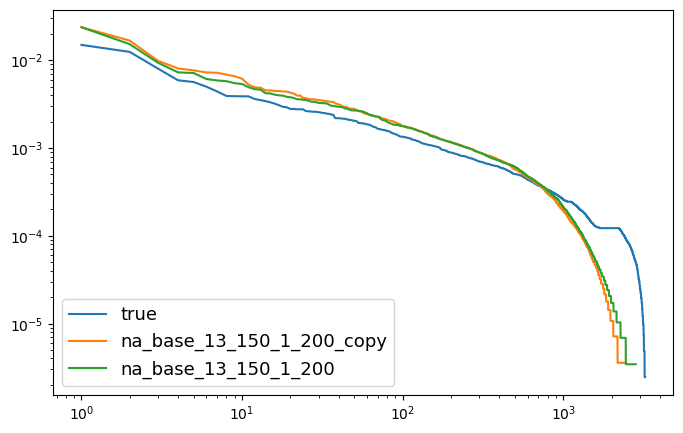

In [314]:
plt.figure(figsize=(8, 5))

plt.plot(np.arange(len(true)) + 1, true, label="true")
# plt.plot(np.arange(len(source)) + 1, source, label="source")
# plotting
for pre, label in zip(predict, diff_file_name):
    plt.plot(np.arange(len(pre)) + 1, pre, label=label)

# plt.plot(np.arange(len(ar)) + 1, ar, label="MHSA decode (Ours)")
# plt.plot(np.arange(len(markov)) + 1, markov, label="Markov")
# plt.plot(np.arange(len(gan)) + 1, gan, label="MovSim")
# plt.plot(np.arange(len(epr)) + 1, epr, label="EPR")
# plt.plot(np.arange(len(container)) + 1, container, label="Container")

plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})
plt.show()

In [232]:
# predict = np.log(predict_p[:100])
# true = np.log(true_p[:100])
# source = np.log(source_p[:100])

predict = predict_p
true = true_p
source = source_p

In [233]:
pred_true_js = distance.jensenshannon(predict, true)
source_true_js = distance.jensenshannon(source, true)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.377	 Source and True: 0.061


In [127]:
markov_true_js = distance.jensenshannon(markov_p, true)
ar_true_js = distance.jensenshannon(ar_p, true)
gan_true_js = distance.jensenshannon(gan_p, true)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

Markov and True: 0.365	 AR and True: 0.166	 GAN and True: 0.214


In [234]:
epr_true_js = distance.jensenshannon(epr_p, true)

print(f"EPR and True: {epr_true_js:.3f}")

EPR and True: 0.221


# Visit frequency - individual location (max 50)

In [315]:
def get_individual_loc_p(ls, max_len = 50):
    visits = np.zeros(shape=(max_len), dtype=float)

    for seq in ls:
        _, counts = np.unique(seq, return_counts=True)
        counts.sort()
        counts = counts[::-1]

        if len(counts) > max_len:
            counts = counts[:max_len]
        else:
            counts = np.pad(counts, (0, max_len - len(counts)))
        
        visits += counts/counts.sum()

    visits = visits/len(ls)
    return visits

In [316]:
predict_ind_p = [get_individual_loc_p(p) for p in predict_ls]

In [317]:
true_ind_p = get_individual_loc_p(true_ls)
source_ind_p = get_individual_loc_p(src_ls)

In [318]:
len(predict_ind_p), predict_ind_p[0]

(2,
 array([0.4737, 0.2169, 0.1149, 0.0688, 0.0441, 0.0288, 0.0189, 0.0124,
        0.008 , 0.0051, 0.0031, 0.0019, 0.0012, 0.0008, 0.0005, 0.0003,
        0.0002, 0.0001, 0.0001, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]))

In [319]:
true_ind_p, source_ind_p

(array([0.4396, 0.21  , 0.0964, 0.0583, 0.0413, 0.0313, 0.0247, 0.02  ,
        0.016 , 0.0131, 0.0107, 0.0087, 0.007 , 0.0055, 0.0043, 0.0034,
        0.0026, 0.002 , 0.0015, 0.0011, 0.0008, 0.0006, 0.0004, 0.0003,
        0.0002, 0.0001, 0.0001, 0.0001, 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]),
 array([0.4132, 0.2123, 0.1157, 0.0576, 0.0361, 0.0263, 0.0203, 0.0165,
        0.0137, 0.0115, 0.0098, 0.0085, 0.0073, 0.0064, 0.0056, 0.0049,
        0.0043, 0.0038, 0.0033, 0.0029, 0.0025, 0.0021, 0.0019, 0.0016,
        0.0014, 0.0012, 0.001 , 0.0009, 0.0008, 0.0007, 0.0006, 0.0005,
        0.0005, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0001, 0.0001]))

In [320]:
predict = [p[p>0] for p in predict_ind_p]
true = true_ind_p[true_ind_p>0]
source = source_ind_p[source_ind_p>0]

In [321]:
markov_p = get_individual_loc_p(markov_ls)
ar_p = get_individual_loc_p(ar_ls)
gan_p = get_individual_loc_p(gan_ls)
epr_ind_p = get_individual_loc_p(epr_ls)
container_ind_p = get_individual_loc_p(container_ls)

markov = markov_p[markov_p>0]
ar = ar_p[ar_p>0]
gan = gan_p[gan_p>0]
epr = epr_ind_p[epr_ind_p>0]
container = container_ind_p[container_ind_p>0]

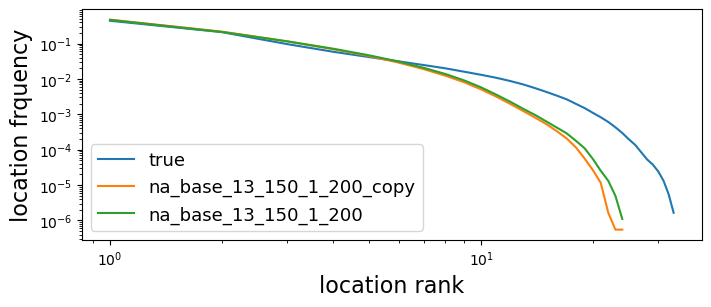

In [322]:
plt.figure(figsize=(8, 3))


# plotting
plt.plot(np.arange(len(true)) + 1, true, label="true")
# plt.plot(np.arange(len(source)) + 1, source, label="source")

for pre, label in zip(predict, diff_file_name):
    plt.plot(np.arange(len(pre)) + 1, pre, label=label)

# plt.plot(np.arange(len(ar)) + 1, ar, label="MHSA decode (Ours)")
# plt.plot(np.arange(len(markov)) + 1, markov, label="Markov", alpha=0.5)
# plt.plot(np.arange(len(gan)) + 1, gan, label="MovSim", alpha=0.5)
# plt.plot(np.arange(len(epr)) + 1, epr, label="EPR", alpha=0.5)
# plt.plot(np.arange(len(container)) + 1, container, label="Container", alpha=0.5)

plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})

plt.xlabel("location rank", fontsize=16)
plt.ylabel("location frquency", fontsize=16)

# plt.savefig(r'.\metrics\figures\lk.png', bbox_inches='tight', dpi=600)
plt.show()


In [496]:
predict = [p[p>0] for p in predict_ind_p]
true = true_ind_p[true_ind_p>0]
source = source_ind_p[source_ind_p>0]

ar = ar_p[ar_p>0]
markov = markov_p[markov_p>0]
gan = gan_p[gan_p>0]
epr = epr_ind_p[epr_ind_p>0]

In [245]:
pred_true_js = distance.jensenshannon(predict_ind_p[0], true_ind_p)
source_true_js = distance.jensenshannon(source_ind_p, true_ind_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.226	 Source and True: 0.069


In [246]:
markov_true_js = distance.jensenshannon(markov_p, true_ind_p)
ar_true_js = distance.jensenshannon(ar_p, true_ind_p)
gan_true_js = distance.jensenshannon(gan_p, true_ind_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

epr_true_js = distance.jensenshannon(epr_ind_p, true_ind_p)

print(f"EPR and True: {epr_true_js:.3f}")

Markov and True: 0.250	 AR and True: 0.070	 GAN and True: 0.223
EPR and True: 0.166


# Rg
## Overall

In [323]:
def get_rg(ls, geo_x, geo_y):
    rgs = []

    for seq in ls:
        locs = seq - 1 # padding

        xs = np.take(geo_x, locs)
        ys = np.take(geo_y, locs)

        x_center = np.average(xs)
        y_center = np.average(ys)

        square_rg = np.average((xs - x_center) ** 2 + (ys - y_center) ** 2)

        rgs.append(np.sqrt(square_rg))
    return np.array(rgs, dtype=float)

In [324]:
geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

In [325]:
predict_rg = [get_rg(p, geo_x, geo_y) for p in predict_ls]

predict_rg = [p[p>1] for p in predict_rg]

In [326]:
true_rg = get_rg(true_ls, geo_x, geo_y)
source_rg = get_rg(src_ls, geo_x, geo_y)

true_rg = true_rg[true_rg>1]
source_rg = source_rg[source_rg>1]

In [327]:
markov_rg = get_rg(markov_ls, geo_x, geo_y)
markov_rg = markov_rg[markov_rg>1]

ar_rg = get_rg(ar_ls, geo_x, geo_y)
ar_rg = ar_rg[ar_rg>1]

gan_rg = get_rg(gan_ls, geo_x, geo_y)
gan_rg = gan_rg[gan_rg>1]

epr_rg = get_rg(epr_ls, geo_x, geo_y)
epr_rg = epr_rg[epr_rg>1]

container_rg = get_rg(container_ls, geo_x, geo_y)
container_rg = container_rg[container_rg>1]

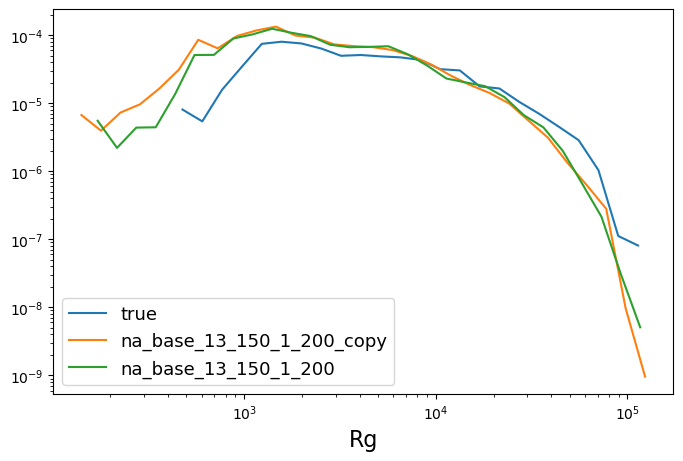

In [328]:
plt.figure(figsize=(8, 5))

# fit power law
fit = powerlaw.Fit(true_rg, xmin=1)

# plotting
powerlaw.plot_pdf(true_rg, label="true")
# powerlaw.plot_pdf(source_rg, label="source")

for pre, label in zip(predict_rg, diff_file_name):
    powerlaw.plot_pdf(pre, label=label)

# powerlaw.plot_pdf(markov_rg, label="markov")
# powerlaw.plot_pdf(ar_rg, label="ar")
# powerlaw.plot_pdf(gan_rg, label="gan")
# powerlaw.plot_pdf(epr_rg, label="epr")
# powerlaw.plot_pdf(container_rg, label="container")

# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.xlabel("Rg", fontsize=16)
plt.legend(prop={"size": 13})
plt.show()

In [232]:
predict = np.log(predict_rg[0])
true = np.log(true_rg)
source = np.log(source_rg)

min = predict.min()
max = predict.max()

In [233]:

pred_rg_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_rg_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_rg_p, _ =  np.histogram(source, bins=1000, range=(min, max))

pred_true_js = distance.jensenshannon(pred_rg_p, true_rg_p)
source_true_js = distance.jensenshannon(source_rg_p, true_rg_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.243	 Source and True: 0.191


In [235]:
markov = np.log(markov_rg)
ar = np.log(ar_rg)
gan = np.log(gan_rg)
epr = np.log(epr_rg)

In [391]:
markov_rg_p, _ =  np.histogram(markov, bins=1000, range=(min, max))
markov_true_js = distance.jensenshannon(markov_rg_p, true_rg_p)

ar_rg_p, _ =  np.histogram(ar, bins=1000, range=(min, max))
ar_true_js = distance.jensenshannon(ar_rg_p, true_rg_p)

gan_rg_p, _ =  np.histogram(gan, bins=1000, range=(min, max))
gan_true_js = distance.jensenshannon(gan_rg_p, true_rg_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

epr_rg_p, _ =  np.histogram(epr, bins=1000, range=(min, max))
epr_true_js = distance.jensenshannon(epr_rg_p, true_rg_p)

print(f"EPR and True: {epr_true_js:.3f}")

NameError: name 'true_rg_p' is not defined

## Evolution

In [329]:
def get_rg_evolution(seq, geo_x, geo_y, max_len=50):
    locs = seq - 1 # padding

    xs = np.take(geo_x, locs)
    ys = np.take(geo_y, locs)

    current_rg = [0]
    for i in range(1, len(xs)):

        x_center = np.average(xs[:i])
        y_center = np.average(ys[:i])

        square_rg = np.average((xs[:i] - x_center) ** 2 + (ys[:i] - y_center) ** 2)

        current_rg.append(np.sqrt(square_rg))
    
    current_rg = np.array(current_rg, dtype=float)
    if len(current_rg) > max_len:
        current_rg = current_rg[:max_len]
    else:
        current_rg = np.pad(current_rg, (0, max_len - len(current_rg)), constant_values=np.nan)
            
    return current_rg

geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values


In [330]:
predict_rge = [_apply_parallel(p, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1) for p in predict_ls]

In [331]:
true_rge = _apply_parallel(true_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)
# source_rge = _apply_parallel(src_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

In [332]:
markov_rge = _apply_parallel(markov_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

epr_rge = _apply_parallel(epr_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

ar_rge = _apply_parallel(ar_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

gan_rge = _apply_parallel(gan_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

container_rge = _apply_parallel(container_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

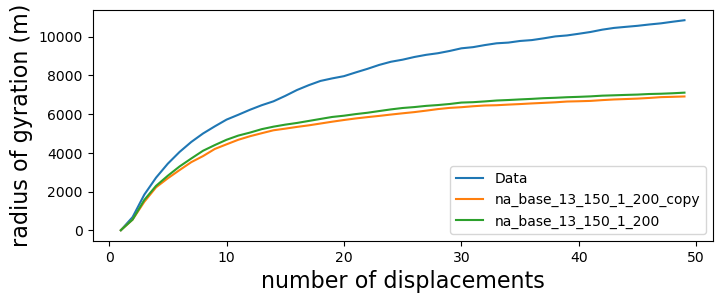

In [333]:
plt.figure(figsize=(8, 3))

x = np.arange(1, 50)

# plotting
plt.plot(x, np.nanmedian(true_rge, axis = 0)[1:], color = colors[0], label="Data")
# plt.plot(x, np.nanquantile(true_rge, q=0.25, axis=0)[1:], '--', color = colors[0], alpha=0.3)
# plt.plot(x, np.nanquantile(true_rge, q=0.75, axis=0)[1:], '--', color = colors[0], alpha=0.3)

# plt.fill_between(x, np.nanquantile(true_rge, q=0.25, axis=0)[1:], np.nanquantile(true_rge, q=0.75, axis=0)[1:], color = colors[0], alpha=0.3)

# plt.plot(source_rge, label="source")

for i, (pre, label) in enumerate(zip(predict_rge, diff_file_name)):
    plt.plot(x, np.nanmedian(pre, axis=0)[1:], color = colors[i+1], label=label)
    # plt.plot(x, np.nanquantile(pre, q=0.25, axis=0)[1:], '--', color = colors[i+1], alpha=0.3)
    # plt.plot(x, np.nanquantile(pre, q=0.75, axis=0)[1:], '--', color = colors[i+1], alpha=0.3)

    # plt.fill_between(x, np.nanquantile(pre, q=0.25, axis=0)[1:], np.nanquantile(pre, q=0.75, axis=0)[1:], color = colors[i+1], alpha=0.3)

# plt.plot(x, np.nanmedian(markov_rge, axis = 0)[1:], color = colors[i+3], label="Markov", alpha=0.5)
# plt.plot(x, np.nanmedian(ar_rge, axis = 0)[1:], color = colors[i+2], label="MHSA decode (Ours)", alpha=0.5)
# plt.plot(x, np.nanmedian(gan_rge, axis = 0)[1:], color = colors[i+4], label="MovSim", alpha=0.5)
# plt.plot(x, np.nanmedian(epr_rge, axis = 0)[1:], color = colors[i+5], label="EPR", alpha=0.5)
# plt.plot(x, np.nanmedian(container_rge, axis = 0)[1:], color = colors[i+6], label="Container", alpha=0.5)

plt.xlabel("number of displacements", fontsize=16)
plt.ylabel("radius of gyration (m)", fontsize=16)
plt.legend(prop={"size": 10})

# plt.savefig(r'.\metrics\figures\rg_evolution.png', bbox_inches='tight', dpi=600)
plt.show()

### Fit

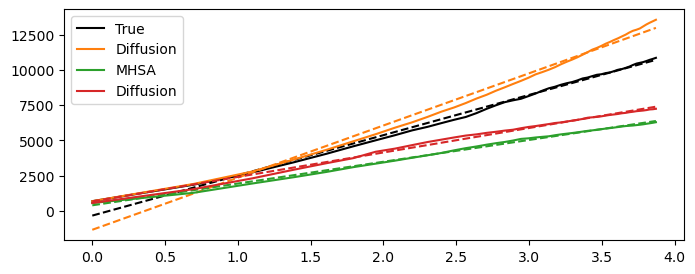

In [162]:
from scipy.stats import linregress

plt.figure(figsize=(8, 3))

y = np.nanmedian(true_rge, axis = 0)[2:]
x = np.log(np.arange(len(y)) + 1)
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color="k",  label="True")
plt.plot(x, x*slope+intercept, "--", color="k")

y = np.nanmedian(container_rge, axis = 0)[2:]
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color=colors[1],  label="Diffusion")
plt.plot(x, x*slope+intercept, "--", color=colors[1])

y = np.nanmedian(ar_rge, axis = 0)[2:]
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color=colors[2],  label="MHSA")
plt.plot(x, x*slope+intercept, "--", color=colors[2])

y = np.nanmedian(predict_rge[0], axis = 0)[2:]
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color=colors[3],  label="Diffusion")
plt.plot(x, x*slope+intercept, "--", color=colors[3])

plt.legend(prop={"size": 10})
plt.show()

In [154]:
slope, intercept

(1736.9619500528113, 664.1125083036186)

# Testing distribution

In [182]:
from utils.utils import load_data, _split_dataset

def get_train_test(sp, all_locs=None):
    sp.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)
    sp.drop(columns={"started_at", "finished_at"}, inplace=True)
    sp["idx"] = sp.groupby("user_id").cumcount().add(1)

    # encoder user, 0 reserved for padding
    enc = OrdinalEncoder(dtype=np.int64)
    sp["user_id"] = enc.fit_transform(sp["user_id"].values.reshape(-1, 1)) + 1

    # split the datasets, user dependent 0.7, 0.2, 0.1
    train_data, vali_data, test_data = _split_dataset(sp)

    # encode unseen locations in validation and test into 0
    enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
        all_locs["loc_id"].values.reshape(-1, 1)
    )
    # add 1 to account for 0 padding
    all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

    train_data["location_id"] = enc.transform(train_data["location_id"].values.reshape(-1, 1)) + 1
    vali_data["location_id"] = enc.transform(vali_data["location_id"].values.reshape(-1, 1)) + 1
    test_data["location_id"] = enc.transform(test_data["location_id"].values.reshape(-1, 1)) + 1

    return train_data, vali_data, test_data, all_locs

def get_data_for_mechanistic(type):
    sp = pd.read_csv(os.path.join(f"./data/sp_{type}.csv"), index_col="id")
    loc = pd.read_csv(os.path.join("./data/loc_s2_level10_13.csv"), index_col="id")

    sp = load_data(sp, loc)

    # get all possible locations
    all_locs = pd.read_csv("./data/s2_loc_visited_level10_13.csv", index_col="id")
    all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
    all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
    # transform to projected coordinate systems
    all_locs = all_locs.to_crs("EPSG:2056")

    train_data, vali_data, test_data, all_locs = get_train_test(sp, all_locs=all_locs)
    print(
        f"Max loc id {all_locs.loc_id.max()}, min loc id {all_locs.loc_id.min()}, unique loc id:{all_locs.loc_id.unique().shape[0]}"
    )

    return train_data, vali_data, test_data, all_locs

train_df, vali_df, test_df, all_locs_df = get_data_for_mechanistic(type="all")

Max loc id 14882, min loc id 2, unique loc id:14881


In [186]:
from sklearn.linear_model import LinearRegression
def get_parameter_estimate(df):
    df.sort_values(by=["start_day", "start_min"], inplace=True)

    loc = df["location_id"].values

    unique_count_ls = []
    for i in range(loc.shape[0]):
        unique_count_ls.append(len(np.unique(loc[: i + 1])))

    # big S
    unique_count_arr = np.array(unique_count_ls)

    # small n
    steps = np.arange(unique_count_arr.shape[0]) + 1

    logy = np.log(unique_count_arr)
    logx = np.log(steps)
    # print(logy, logx)
    reg = LinearRegression().fit(logx.reshape(-1, 1), logy)

    r = 1 / reg.coef_ - 1
    p = np.exp((reg.intercept_ - np.log(1 + r)) * (1 + r))

    return pd.Series([r[0], p[0]], index=["r", "p"])

train_vali_data = pd.concat([train_df, vali_df])
param_estimate = train_vali_data.groupby("user_id").apply(get_parameter_estimate)

In [189]:
from scipy.stats import norm
norm.fit(param_estimate.r), norm.fit(param_estimate.p)

((0.631684130639635, 0.3078206120000065),
 (0.5256114632862874, 0.27405772148554913))

In [190]:
param_estimate = param_estimate.loc[param_estimate["p"]<1]

array([[<Axes: title={'center': 'r'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

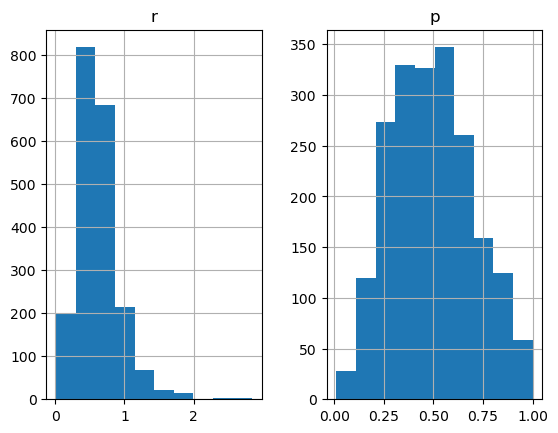

In [192]:
param_estimate.hist()

In [193]:
norm.fit(param_estimate.r), norm.fit(param_estimate.p)

((0.6217721474035965, 0.3032468230238075),
 (0.4943456871979018, 0.20562538359456128))

In [306]:
duration_hour = train_vali_data["act_duration"].values / 60
duration_hour = duration_hour[duration_hour > 0.1]

fit = powerlaw.Fit(duration_hour, xmin=0.1, xmin_distribution="lognormal")
# print("AIC criteria for wait time:", getAIC(fit, duration_hour))
print(f"Lognormal: parameter1: {fit.lognormal.parameter1:.4f}\t parameter2: {fit.lognormal.parameter2:.4f}")
# print(
#     f"Truncated power law: parameter1: {fit.truncated_power_law.parameter1:.2f}\t parameter2: {fit.truncated_power_law.parameter2:.2f}"
# )
# print(f"Power law: alpha: {fit.power_law.alpha:.2f}")


Lognormal: parameter1: 0.9748	 parameter2: 1.4316


In [311]:
duration_hour.max()

2013.6666666666667

In [312]:
fit.distribution_compare('power_law', 'exponential')

(-304319.6466017017, 0.0)

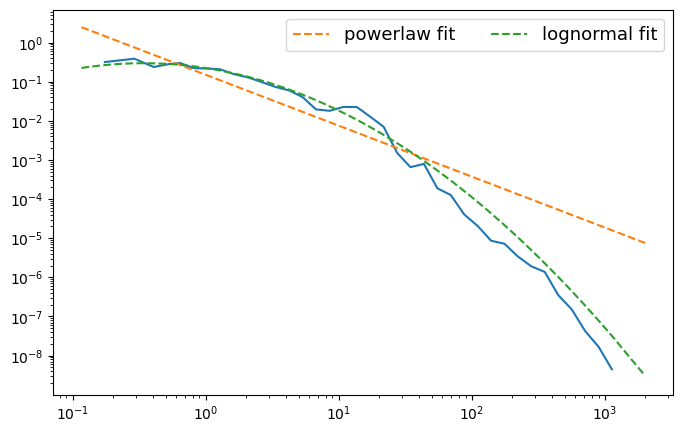

In [198]:
plt.figure(figsize=(8,5))

powerlaw.plot_pdf(duration_hour)

fit.power_law.plot_pdf(linestyle = '--', label='powerlaw fit')
# fit.truncated_power_law.plot_pdf(linestyle = '--', label='truncated power law')
fit.lognormal.plot_pdf(linestyle = '--', label='lognormal fit')

plt.legend(prop={'size': 13}, ncol=2)

plt.show()

In [313]:
train_vali_data["geometry"] = train_vali_data["geometry"].apply(wkt.loads)

TypeError: Expected bytes or string, got Point

In [314]:
from trackintel.geogr import point_haversine_dist
def get_jump_length(gdf):
    geom_arr = gdf.geometry.values

    res_ls = []
    for i in range(1, len(geom_arr)):
        res_ls.append(point_haversine_dist(geom_arr[i - 1].x, geom_arr[i - 1].y, geom_arr[i].x, geom_arr[i].y)[0])
    return res_ls


jump_length = gpd.GeoDataFrame(train_vali_data, geometry="geometry").groupby("user_id").apply(get_jump_length)


In [315]:
jump_length

user_id
1       [281.4220762892863, 1646.0597839192035, 2.5153...
2       [155.18895767606526, 221.79356387054705, 26330...
3       [1209.6737790118673, 240.78123913861543, 1334....
4       [123843.69073783064, 10414.004688691146, 1195....
5       [8.588890376360753, 55879.11369479354, 1605.63...
                              ...                        
2108    [228.16955784604625, 222.54524713864237, 50848...
2109    [4.1009411544915535, 62234.457307382705, 31556...
2110    [2.258582367933473, 2.0777604465263058, 1365.7...
2111    [497.91750127566246, 3433.3350937983655, 3425....
2112    [431.8709694992403, 275.23958168598085, 577.94...
Length: 2112, dtype: object

In [316]:
flat_jump_length = np.array([item for sublist in jump_length.to_list() for item in sublist])
flat_jump_length = flat_jump_length[flat_jump_length > 20]

In [317]:
fit = powerlaw.Fit(flat_jump_length, xmin=20, xmin_distribution='lognormal')
print(f"Lognormal: parameter1: {fit.lognormal.parameter1:.4f}\t parameter2: {fit.lognormal.parameter2:.4f}")

Lognormal: parameter1: 7.4534	 parameter2: 2.0797


In [321]:
fit.distribution_compare('truncated_power_law', 'power_law')

Assuming nested distributions


(283658.73046166607, 0.0)

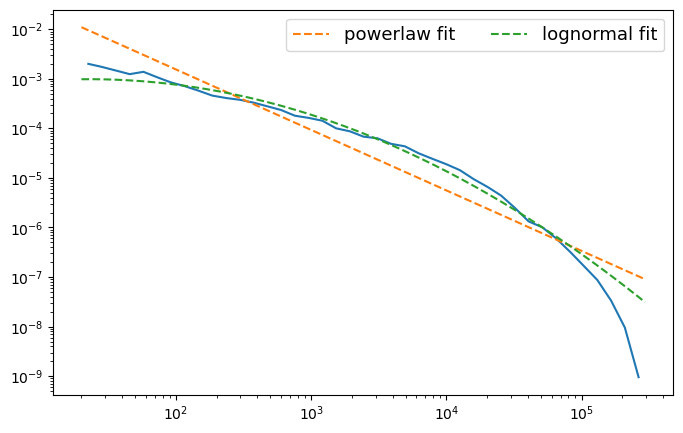

In [206]:
plt.figure(figsize=(8,5))

powerlaw.plot_pdf(flat_jump_length)

fit.power_law.plot_pdf(linestyle = '--', label='powerlaw fit')
# fit.truncated_power_law.plot_pdf(linestyle = '--', label='truncated power law')
fit.lognormal.plot_pdf(linestyle = '--', label='lognormal fit')

plt.legend(prop={'size': 13}, ncol=2)

plt.show()

# Language metrics

In [46]:
def bleu_score(recover, reference):
    return sentence_bleu(
        [reference],
        recover,
        smoothing_function=SmoothingFunction().method4,
    )

def get_scores(pred_ls, ref_ls):
    bleu_ls = []
    for pred, ref in zip(pred_ls, ref_ls):

        bleu_ls.append(bleu_score(pred, ref))
    return bleu_ls

def get_self_bleu(ls):
    selfBleu = []
    for i, seq in tqdm(enumerate(ls)):
        for j in range(i + 1, len(ls)):
            score = bleu_score(seq, ls[j])
            selfBleu.append(score)
    return np.mean(selfBleu)

def distinct_n_gram_inter_sent(hypn, n):
    hyp_ngrams = []
    for hyp in hypn:
        hyp_ngrams += nltk.ngrams(hyp, n)
    total_ngrams = len(hyp_ngrams)
    unique_ngrams = len(list(set(hyp_ngrams)))

    dist_n = unique_ngrams / total_ngrams
    return dist_n

def distinct_n_gram(hypn, n=1):
    dist_list = []
    for hyp in hypn:
        n1_grams = list(nltk.ngrams(hyp, n))
        dist_list.append(len(set(n1_grams))/len(n1_grams))
    return np.mean(dist_list)

## BLEU

In [47]:
predict_src_bleu = [get_scores(p, src_ls) for p in predict_ls]
predict_true_bleu = [get_scores(p, true_ls) for p in predict_ls]

In [48]:
true_src_bleu = get_scores(true_ls, src_ls)

In [49]:
print(f"Source and True: {np.average(true_src_bleu):.3f}")
for ps, pt, label in zip(predict_src_bleu, predict_true_bleu, diff_file_name):
    print(f"{label} and True: {np.average(pt):.3f}\t\t{label} and Source: {np.average(ps):.3f}")

Source and True: 0.089
na_multi_layer2_cond_13_150_1_20 and True: 0.079		na_multi_layer2_cond_13_150_1_20 and Source: 0.025


In [2075]:
markov_true_bleu = get_scores(markov_ls, true_ls)
ar_true_bleu = get_scores(ar_ls, true_ls)
gan_true_bleu = get_scores(gan_ls, true_ls)

print(f"Markov and True: {np.average(markov_true_bleu):.3f}\nAR and True: {np.average(ar_true_bleu):.3f}\nGAN and True: {np.average(gan_true_bleu):.3f}")

Markov and True: 0.204
AR and True: 0.186
GAN and True: 0.001


In [194]:
epr_true_bleu = get_scores(epr_ls, true_ls)

print(f"EPR and True: {np.average(epr_true_bleu):.3f}")

EPR and True: 0.095


## Self-bleu
Lower self-bleu suggests higher diversity

In [98]:
# slow
predict_bleu = get_self_bleu(predict_ls)
true_bleu = get_self_bleu(true_ls)
src_bleu = get_self_bleu(src_ls)

1it [00:05,  5.78s/it]


KeyboardInterrupt: 

## Diverse 4-gram
Higher div-4 suggests higher diversity

In [50]:
pred_div4 = [distinct_n_gram_inter_sent(p, 4) for p in predict_ls]
true_div4 = distinct_n_gram_inter_sent(true_ls, 4)
src_div4 = distinct_n_gram_inter_sent(src_ls, 4)

print(f"Source: {src_div4:.4f}\nTrue: {true_div4:.4f}")
for div, label in zip(pred_div4, diff_file_name):
    
    print(f"{label}: {div:.4f}")

Source: 0.0140
True: 0.0183
na_multi_layer2_cond_13_150_1_20: 0.1518


In [2077]:
markov_div4 = distinct_n_gram_inter_sent(markov_ls, 4)
ar_div4 = distinct_n_gram_inter_sent(ar_ls, 4)
gan_div4 = distinct_n_gram_inter_sent(gan_ls, 4)

print(f"Markov: {markov_div4:.4f}\nAR: {ar_div4:.4f}\nGAN: {gan_div4:.4f}")

Markov: 0.0120
AR: 0.2612
GAN: 0.4934


In [2078]:
epr_div4 = distinct_n_gram_inter_sent(epr_ls, 4)

print(f"EPR: {epr_div4:.4f}")

EPR: 0.6146


## Distinct unigrams (1-gram)
intra-diversity within each sequence. Lower dist means more repeated tokens.

In [51]:
predict_1_gram = [distinct_n_gram(p) for p in predict_ls]
true_1_gram = distinct_n_gram(true_ls)
src_1_gram = distinct_n_gram(src_ls)

print(f"Source: {src_1_gram:.4f}\nTrue: {true_1_gram:.4f}")
for gram, label in zip(predict_1_gram, diff_file_name):
    print(f"{label}: {gram:.4f}")

Source: 0.1382
True: 0.2387
na_multi_layer2_cond_13_150_1_20: 0.0946


In [338]:
markov_1_gram = distinct_n_gram(markov_ls)
ar_1_gram = distinct_n_gram(ar_ls)
gan_1_gram = distinct_n_gram(gan_ls)

print(f"Markov: {markov_1_gram:.4f}\nAR: {ar_1_gram:.4f}\nGAN: {gan_1_gram:.4f}")

Markov: 0.0770
AR: 0.1999
GAN: 0.3890


In [339]:
epr_1_gram = distinct_n_gram(epr_ls)

print(f"EPR: {epr_1_gram:.4f}")

EPR: 0.3661


# Entropy
## Real entropy

In [334]:
def real_entropy_individual(locs_series):

    n = len(locs_series)

    # 1 to ensure to consider the first situation from where
    # locs_series[i:j] = [] and locs_series[i:j] = locs_series[0:1]
    sum_lambda = 1

    for i in range(1, n - 1):
        j = i + 1

        while True:
            # if the locs_series[i:j] is longer than locs_series[:i],
            # we can no longer find it locs_series[i:j] in locs_series[:i]
            if j - i > i:
                break

            # if locs_series[i:j] exist in locs_series[:i], we increase j by 1
            # sliding_window_view creates sublist of length len(locs_series[i:j]) from locs_series[:i]
            ls = np.lib.stride_tricks.sliding_window_view(locs_series[:i], j - i).tolist()
            if tuple(locs_series[i:j]) in list(map(tuple, ls)):
                # if the subsequence already exist, we increase the sequence by 1, and check again
                j += 1
            else:
                # we find the "shortest substring" that does not exist in locs_series[:i]
                break

        # length of the substring
        sum_lambda += j - i

    # the function S5 from the suppl. material
    return 1.0 / (sum_lambda * 1 / n) * np.log(n)



In [335]:
predict_re = [_apply_parallel(p, real_entropy_individual, n=-1) for p in predict_ls]

In [336]:
true_re = _apply_parallel(true_ls, real_entropy_individual, n=-1)
# source_re = _apply_parallel(src_ls, real_entropy_individual, n=-1)

In [114]:
markov_re = _apply_parallel(markov_ls, real_entropy_individual, n=-1)
ar_re = _apply_parallel(ar_ls, real_entropy_individual, n=-1)
gan_re = _apply_parallel(gan_ls, real_entropy_individual, n=-1)
epr_re = _apply_parallel(epr_ls, real_entropy_individual, n=-1)

container_re = _apply_parallel(container_ls, real_entropy_individual, n=-1)

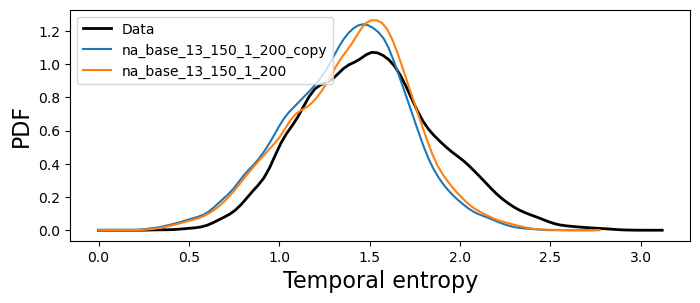

In [337]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

density = stats.gaussian_kde(true_re)
x = np.linspace(0, np.max(true_re) + 0.2, 100)
ax.plot(x, density(x), label="Data", color="k", linewidth=2)

# density = stats.gaussian_kde(source_re)
# x = np.linspace(0, np.max(source_re) + 0.2, 100)
# ax.plot(x, density(x), label="source")

for pre, label in zip(predict_re, diff_file_name):
    density = stats.gaussian_kde(pre)
    x = np.linspace(0, np.max(pre) + 0.2, 100)
    ax.plot(x, density(x), label=label)

# density = stats.gaussian_kde(ar_re)
# x = np.linspace(0, np.max(ar_re) + 0.2, 100)
# ax.plot(x, density(x), label="MHSA (Ours)")

# density = stats.gaussian_kde(markov_re)
# x = np.linspace(0, np.max(markov_re) + 0.2, 100)
# ax.plot(x, density(x), label="Markov")

# density = stats.gaussian_kde(gan_re)
# x = np.linspace(0, np.max(gan_re) + 0.2, 100)
# ax.plot(x, density(x), label="MovSim")

# density = stats.gaussian_kde(epr_re)
# x = np.linspace(0, np.max(epr_re) + 0.2, 100)
# ax.plot(x, density(x), label="EPR")

# density = stats.gaussian_kde(container_re)
# x = np.linspace(0, np.max(container_re) + 0.2, 100)
# ax.plot(x, density(x), label="Container")

plt.legend(prop={"size": 10}, loc=2)
plt.xlabel("Temporal entropy", fontsize=16)
plt.ylabel("PDF", fontsize=16)

# plt.savefig(r'.\metrics\figures\entropy_tem.png', bbox_inches='tight', dpi=600)
plt.show()

In [253]:
predict_density = stats.gaussian_kde(predict_re)
true_density = stats.gaussian_kde(true_re)
source_density = stats.gaussian_kde(source_re)

x = np.linspace(0, 3, 1000)

pred_true_re = distance.jensenshannon(predict_density(x), true_density(x))
source_true_re = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_re:.3f}\t Source and True: {source_true_re:.3f}")

Prediction and True: 0.414	 Source and True: 0.047


In [102]:
markov_density = stats.gaussian_kde(markov_re)
ar_density = stats.gaussian_kde(ar_re)
gan_density = stats.gaussian_kde(gan_re)

markov_true_re = distance.jensenshannon(markov_density(x), true_density(x))
ar_true_re = distance.jensenshannon(ar_density(x), true_density(x))
gan_true_re = distance.jensenshannon(gan_density(x), true_density(x))

print(f"Markov and True: {markov_true_re:.3f}\t AR and True: {ar_true_re:.3f}\t GAN and True: {gan_true_re:.3f}")

Markov and True: 0.624	 AR and True: 0.206	 GAN and True: 0.316


In [254]:
epr_density = stats.gaussian_kde(epr_re)

epr_true_re = distance.jensenshannon(epr_density(x), true_density(x))

print(f"EPR and True: {epr_true_re:.3f}")

EPR and True: 0.436


## Uncorrelated entropy

In [338]:
def uncorrelated_entropy_individual(locs_series):
    _, counts = np.unique(locs_series, return_counts=True)
    freq = counts/len(locs_series)
    return -(freq * np.log(freq)).sum()


In [339]:
predict_ue = [[uncorrelated_entropy_individual(seq) for seq in p] for p in predict_ls]

In [340]:
true_ue = [uncorrelated_entropy_individual(seq) for seq in true_ls]
source_ue = [uncorrelated_entropy_individual(seq) for seq in src_ls]

In [341]:
markov_ue = [uncorrelated_entropy_individual(seq) for seq in markov_ls]
ar_ue = [uncorrelated_entropy_individual(seq) for seq in ar_ls]
gan_ue = [uncorrelated_entropy_individual(seq) for seq in gan_ls]
epr_ue = [uncorrelated_entropy_individual(seq) for seq in epr_ls]
container_ue = [uncorrelated_entropy_individual(seq) for seq in container_ls]

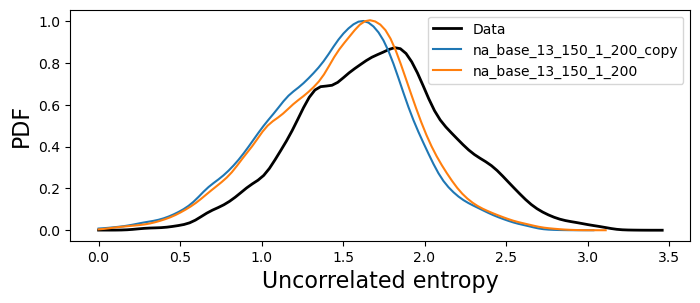

In [342]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

density = stats.gaussian_kde(true_ue)
x = np.linspace(0, np.max(true_ue) + 0.2, 100)
ax.plot(x, density(x), label="Data", color="k", linewidth=2)

# density = stats.gaussian_kde(source_ue)
# x = np.linspace(0, np.max(source_ue) + 0.2, 100)
# ax.plot(x, density(x), label="source")

for pre, label in zip(predict_ue, diff_file_name):
    density = stats.gaussian_kde(pre)
    x = np.linspace(0, np.max(pre) + 0.2, 100)
    ax.plot(x, density(x), label=label)

# density = stats.gaussian_kde(ar_ue)
# x = np.linspace(0, np.max(ar_ue) + 0.2, 100)
# ax.plot(x, density(x), label="MHSA (Ours)")

# density = stats.gaussian_kde(markov_ue)
# x = np.linspace(0, np.max(markov_ue) + 0.2, 100)
# ax.plot(x, density(x), label="Markov")

# density = stats.gaussian_kde(gan_ue)
# x = np.linspace(0, np.max(gan_ue) + 0.2, 100)
# ax.plot(x, density(x), label="MovSim")

# density = stats.gaussian_kde(epr_ue)
# x = np.linspace(0, np.max(epr_ue) + 0.2, 100)
# ax.plot(x, density(x), label="EPR")

# density = stats.gaussian_kde(container_ue)
# x = np.linspace(0, np.max(container_ue) + 0.2, 100)
# ax.plot(x, density(x), label="Container")


plt.legend(prop={"size": 10})
plt.xlabel("Uncorrelated entropy", fontsize=16)
plt.ylabel("PDF", fontsize=16)

# plt.savefig(r'.\metrics\figures\entropy_unc.png', bbox_inches='tight', dpi=600)
plt.show()


In [258]:
predict_density = stats.gaussian_kde(predict_ue)
true_density = stats.gaussian_kde(true_ue)
source_density = stats.gaussian_kde(source_ue)

x = np.linspace(0, 3, 1000)

pred_true_ue = distance.jensenshannon(predict_density(x), true_density(x))
source_true_ue = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_ue:.3f}\t Source and True: {source_true_ue:.3f}")

Prediction and True: 0.454	 Source and True: 0.109


In [107]:
markov_density = stats.gaussian_kde(markov_ue)
markov_true_ue = distance.jensenshannon(markov_density(x), true_density(x))

ar_density = stats.gaussian_kde(ar_ue)
ar_true_ue = distance.jensenshannon(ar_density(x), true_density(x))

gan_density = stats.gaussian_kde(gan_ue)
gan_true_ue = distance.jensenshannon(gan_density(x), true_density(x))

print(f"Markov and True: {markov_true_ue:.3f}\t AR and True: {ar_true_ue:.3f}\t GAN and True: {gan_true_ue:.3f}")

Markov and True: 0.575	 AR and True: 0.209	 GAN and True: 0.483


In [259]:
epr_density = stats.gaussian_kde(epr_ue)
epr_true_ue = distance.jensenshannon(epr_density(x), true_density(x))

print(f"EPR and True: {epr_true_ue:.3f}")

EPR and True: 0.471


## Difference between real and uncorrelated

In [343]:
pred_diff = [[re - ue for re, ue in zip(r,u)] for r,u in zip(predict_re, predict_ue)]

In [344]:
true_diff = [re - ue for re, ue in zip(true_re,true_ue)]
# source_diff = [re - ue for re, ue in zip(source_re,source_ue)]

In [123]:
markov_diff = [re - ue for re, ue in zip(markov_re,markov_ue)]
ar_diff = [re - ue for re, ue in zip(ar_re,ar_ue)]
gan_diff = [re - ue for re, ue in zip(gan_re,gan_ue)]
epr_diff = [re - ue for re, ue in zip(epr_re, epr_ue)]
container_diff = [re - ue for re, ue in zip(container_re, container_ue)]

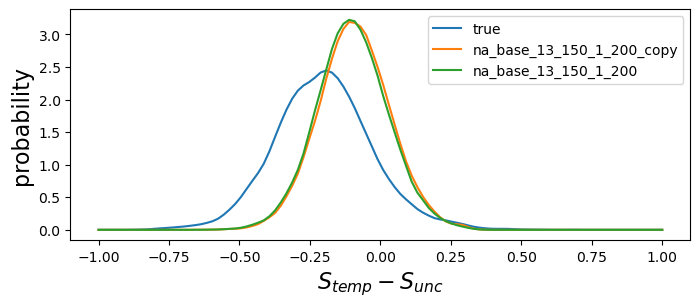

In [345]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

x = np.linspace(-1, 1, 100)

density = stats.gaussian_kde(true_diff)
ax.plot(x, density(x), label="true")

# density = stats.gaussian_kde(source_diff)
# x = np.linspace(-1, 1, 100)
# ax.plot(x, density(x), label="source")

for pre, label in zip(pred_diff, diff_file_name):
    density = stats.gaussian_kde(pre)
    ax.plot(x, density(x), label=label)

# density = stats.gaussian_kde(ar_diff)
# ax.plot(x, density(x), label="MHSA (ours)")

# density = stats.gaussian_kde(markov_diff)
# ax.plot(x, density(x), label="Markov", alpha=0.5)

# density = stats.gaussian_kde(gan_diff)
# ax.plot(x, density(x), label="MovSim", alpha=0.5)

# density = stats.gaussian_kde(epr_diff)
# ax.plot(x, density(x), label="EPR", alpha=0.5)

# density = stats.gaussian_kde(container_diff)
# ax.plot(x, density(x), label="Container", alpha=0.5)

plt.legend(prop={"size": 10})
plt.xlabel("$S_{temp} - S_{unc}$", fontsize=16)
plt.ylabel("probability", fontsize=16)

# plt.savefig(r'.\metrics\figures\ent_diff.png', bbox_inches='tight', dpi=600)
plt.show()

In [253]:
predict_density = stats.gaussian_kde(pred_diff[0])
true_density = stats.gaussian_kde(true_diff)
source_density = stats.gaussian_kde(source_diff)

x = np.linspace(-1, 1, 1000)

pred_true_diff = distance.jensenshannon(predict_density(x), true_density(x))
source_true_diff = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_diff:.3f}\t Source and True: {source_true_diff:.3f}")

Prediction and True: 0.532	 Source and True: 0.263


In [254]:
markov_density = stats.gaussian_kde(markov_diff)
markov_true_diff = distance.jensenshannon(markov_density(x), true_density(x))

ar_density = stats.gaussian_kde(ar_diff)
ar_true_diff = distance.jensenshannon(ar_density(x), true_density(x))

gan_density = stats.gaussian_kde(gan_diff)
gan_true_diff = distance.jensenshannon(gan_density(x), true_density(x))

print(f"Markov and True: {markov_true_diff:.3f}\t AR and True: {ar_true_diff:.3f}\t GAN and True: {gan_true_diff:.3f}")

Markov and True: 0.340	 AR and True: 0.141	 GAN and True: 0.717


In [255]:
epr_density = stats.gaussian_kde(epr_diff)
epr_true_diff = distance.jensenshannon(epr_density(x), true_density(x))

print(f"EPR and True: {epr_true_diff:.3f}")

EPR and True: 0.389


### Log-likelihood Ratio

In [327]:
predict_lk = predict_density.logpdf(true_diff)
epr_lk = epr_density.logpdf(true_diff)

In [335]:
markov_lk = markov_density.logpdf(true_diff)
ar_lk = ar_density.logpdf(true_diff)

In [337]:
def loglikelihood_ratio(loglikelihoods1, loglikelihoods2,normalized_ratio=False):
    from numpy import sqrt
    from scipy.special import erfc

    n = float(len(loglikelihoods1))

    if n==0:
        R = 0
        p = 1
        return R, p
    from numpy import asarray
    loglikelihoods1 = asarray(loglikelihoods1)
    loglikelihoods2 = asarray(loglikelihoods2)

    #Clean for extreme values, if any
    from numpy import inf, log
    from sys import float_info
    min_val = log(10**float_info.min_10_exp)
    loglikelihoods1[loglikelihoods1==-inf] = min_val
    loglikelihoods2[loglikelihoods2==-inf] = min_val

    R = sum(loglikelihoods1-loglikelihoods2)

    from numpy import mean
    mean_diff = mean(loglikelihoods1)-mean(loglikelihoods2)
    variance = sum(( (loglikelihoods1-loglikelihoods2) - mean_diff)**2)/n

    p = erfc( abs(R) / sqrt(2*n*variance))

    return R, p


(-14554.282355123138, 0.0)

In [338]:
loglikelihood_ratio(predict_lk, markov_lk)

(-45057.917133547104, 8.342522715116849e-282)

In [339]:
loglikelihood_ratio(predict_lk, ar_lk)

(-59612.19948867087, 0.0)

In [340]:
loglikelihood_ratio(markov_lk, ar_lk)

(-14554.282355123138, 0.0)

In [329]:
R

104632.93332755628

# Duration and mode
## Reading

In [346]:
file_dir = [    
    # ".\\data\\validation\\na_dur_loss_layer2_cond_13_150_1_20.json",
    # ".\\data\\validation\\na_dur_loss_layer2_cond_13_150_1_200.json",
    
    # ".\\data\\validation\\na_multi_layer2_cond_13_150_1_200.json",
    # ".\\data\\validation\\na_dur_layer2_cond_13_150_1_200.json",

    ".\\data\\validation\\na_base_13_150_1_200.json",
    ".\\data\\validation\\na_base_13_150_1_200_copy.json",
    # ".\\data\\validation\\na_base_smallLoss_13_150_1_200.json",
    # ".\\data\\validation\\na_smallLoss_13_150_1_200.json",
    # ".\\data\\validation\\na_13_150_1_200.json",
    
]

LENGTH = 50
MIN_PER_DAY = 60*24

pred_df_all = []
tgt_df = pd.DataFrame()

tgt = {
    "loc": [],
    "dur": [],
    "mode":[],
    "idx": [],
    "day": [],
    "day_min":[],
}
src = {
    "loc":[],
    "dur":[],
    "mode":[],
    "idx":[],
}

def get_unpadded_sequence(content, dataset="target"):
    locations = np.array(content[dataset])
    if dataset=="target":
        dur_seq = "tgt_dur"
        mode_seq = "tgt_mode"
    else:
        dur_seq = "src_dur"
        mode_seq = "src_mode"
    durations = (np.array(content[dur_seq]) + 1) / 2 * (MIN_PER_DAY * 2)
    modes = np.array(content[mode_seq])
    try:
        length = np.where(locations == 0)[0][0]
        
        locations = locations[:length]
        durations = durations[:length]
        modes = modes[:length]
    except IndexError:
        pass

    return locations, durations, modes
    
for i, file in enumerate(file_dir):
    predict = {
        "loc": [],
        "dur": [],
        "mode":[],
        "idx": [],
        "day": [],
        "day_min":[],
    }
    with open(file, "r") as f_reader:
        for record_idx, row in enumerate(f_reader):
            content = json.loads(row)
            start_time = np.array(content["seq_time"])
            
            if i == 0:
                src_locs, src_dur, src_mode = get_unpadded_sequence(content, dataset="source")

                src["idx"].extend(np.repeat(record_idx,len(src_locs)))
                src["loc"].extend(src_locs)
                src["dur"].extend(src_dur)
                src["mode"].extend(src_mode)
                
                tgt_locs, tgt_dur, tgt_mode = get_unpadded_sequence(content, dataset="target")

                tgt["idx"].extend(np.repeat(record_idx,len(tgt_locs)))
                tgt["loc"].extend(tgt_locs)
                tgt["dur"].extend(tgt_dur)
                tgt["mode"].extend(tgt_mode)

                abs_time = start_time + np.cumsum(tgt_dur)
                tgt["day"].extend((abs_time // MIN_PER_DAY).astype(int))
                tgt["day_min"].extend(abs_time % MIN_PER_DAY)

            predict["idx"].extend(np.repeat(record_idx,LENGTH))
            predict["loc"].extend(np.array(content["recover"][:LENGTH]).squeeze())
            predict["mode"].extend(np.array(content["mode"][:LENGTH]).squeeze())
            
            duration = np.array(content["duration"][:LENGTH]).squeeze()
            predict["dur"].extend(duration)
            
            abs_time = start_time + np.cumsum(duration)
            predict["day"].extend((abs_time // MIN_PER_DAY).astype(int))
            predict["day_min"].extend(abs_time % MIN_PER_DAY)

    if  i == 0:
        src_df = pd.DataFrame(src)
        tgt_df = pd.DataFrame(tgt)
    pred_df_all.append(pd.DataFrame(predict))

In [347]:
print(tgt_df["loc"].max(), src_df["loc"].max())
print([df["loc"].max() for df in pred_df_all])

14881 14881
[14870, 14906]


In [348]:
for df in pred_df_all:
    df.loc[df["loc"]>14881, "loc"] = 14881

In [349]:
diff_file_name = [name.split("\\")[-1].split(".")[0] for name in file_dir]
# diff_file_name = ["Diffusion (Ours)"]
# diff_file_name = ["Base", "Base + xy + POI"]
diff_file_name 

['na_base_13_150_1_200', 'na_base_13_150_1_200_copy']

## Duration distribution

In [350]:
duration_df_all = []
for df in pred_df_all:
    new_df = df.copy()
    new_df.loc[new_df["dur"]<1, "dur"] = 1

    duration_df_all.append(new_df)

In [351]:
duration_df_all[0]["dur"].mean(), pred_df_all[0]["dur"].mean()

(48.10703070597501, 48.039436988086955)

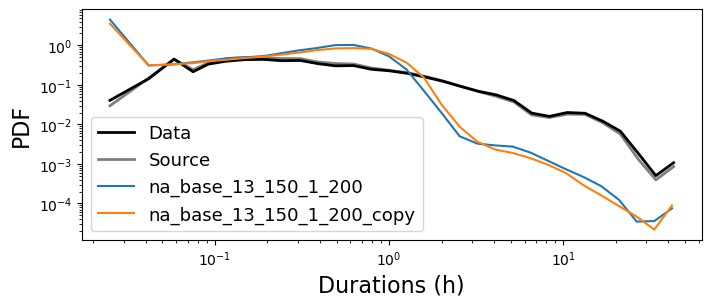

In [368]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

x = np.linspace(0, np.max(tgt_df["dur"]), 500)

# ax.plot(x, density(x), label="true")

powerlaw.plot_pdf(tgt_df["dur"] / 60, label="Data", color="k", linewidth=2)

powerlaw.plot_pdf(src_df.loc[src_df["dur"] != 0, "dur"].values / 60, label="Source", color="k", alpha=0.5, linewidth=2)
for curr_df, label in zip(duration_df_all, diff_file_name):
    powerlaw.plot_pdf(curr_df["dur"] / 60, label=label)

# plt.xscale("linear")
# plt.yscale("linear")

# plt.ylim(10**-12, 10**-2)
# plt.xlim(10**-1, 2880)

plt.legend(prop={"size": 13})
plt.xlabel("Durations (h)", fontsize=16)
plt.ylabel("PDF", fontsize=16)

# plt.savefig(r'.\metrics\figures\duration.png', bbox_inches='tight', dpi=600)
plt.show()

## Mode distribution

In [353]:
['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk']

In [354]:
unique, counts = np.unique(tgt_df["mode"], return_counts=True)
print(unique)
print(counts/counts.sum() * 100)

_, counts = np.unique(src_df["mode"], return_counts=True)
print(counts/counts.sum() * 100)

[1 2 3 4 5 6 7]
[ 6.3339  4.4472 43.071   0.1212  8.5275  1.5517 35.9476]
[ 7.1131  4.3492 43.7174  0.1478  7.2796  1.4033 35.9895]


In [355]:
for pred_df, label in zip(pred_df_all, diff_file_name):
    curr_arr = np.array(pred_df["mode"])
    unique, counts = np.unique(curr_arr, return_counts=True)
    print(label)
    print(unique)
    print(counts/counts.sum() * 100)

na_base_13_150_1_200
[1 2 3 4 5 6 7]
[ 8.343   3.5208 45.4411  0.0363  4.1883  1.1077 37.3629]
na_base_13_150_1_200_copy
[1 2 3 4 5 6 7]
[ 7.5055  3.3144 45.4146  0.0197  4.0023  1.1135 38.63  ]


### Divergence

In [356]:
_, true_counts = np.unique(tgt_df["mode"], return_counts=True)
true_counts = true_counts/true_counts.sum()

_, src_counts = np.unique(src_df["mode"], return_counts=True)
src_counts = src_counts/src_counts.sum()
print(distance.jensenshannon(src_counts, true_counts))

for pred_df, label in zip(pred_df_all, diff_file_name):
    print(label)
    _, pred_counts = np.unique(pred_df["mode"], return_counts=True)

    print(distance.jensenshannon(pred_counts/pred_counts.sum(), true_counts))

0.019988522066517495
na_base_13_150_1_200
0.07259891385933785
na_base_13_150_1_200_copy
0.07498682229142749


## Location per day

In [357]:
def get_day_unique_locs(df):
    _, counts = np.unique(df.groupby(["idx", "day"])["loc"].nunique(), return_counts=True)
    return counts/counts.sum()

tgt_unique_counts = get_day_unique_locs(tgt_df)

In [358]:
pred_unique_counts_ls = [get_day_unique_locs(df) for df in pred_df_all]

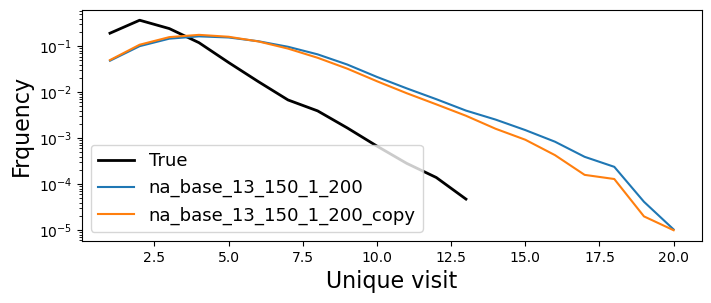

In [359]:
plt.figure(figsize=(8, 3))

# plotting
plt.plot(np.arange(len(tgt_unique_counts)) + 1, tgt_unique_counts, color="k", linewidth=2, label="True")

for pred_unique_counts, label in zip(pred_unique_counts_ls, diff_file_name):
    plt.plot(np.arange(len(pred_unique_counts)) + 1, pred_unique_counts, label=label)

# plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})

plt.xlabel("Unique visit", fontsize=16)
plt.ylabel("Frquency", fontsize=16)

# plt.savefig(r'.\metrics\figures\lk.png', bbox_inches='tight', dpi=600)
plt.show()

In [360]:
def get_day_locs(df):
    _, counts = np.unique(df.groupby(["idx", "day"])["loc"].count(), return_counts=True)
    return counts/counts.sum()

tgt_counts = get_day_locs(tgt_df)

In [361]:
pred_counts_ls = [get_day_locs(df) for df in pred_df_all]

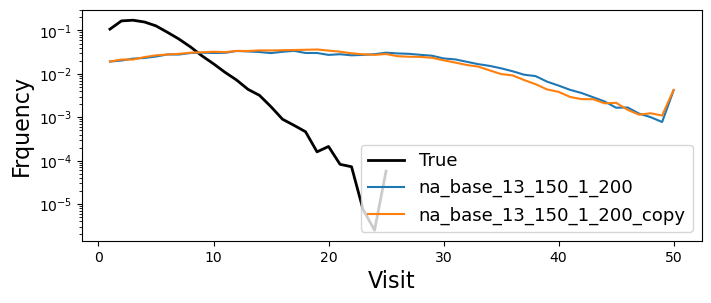

In [362]:
plt.figure(figsize=(8, 3))

# plotting
plt.plot(np.arange(len(tgt_counts)) + 1, tgt_counts, color="k", linewidth=2, label="True")

for pred_counts, label in zip(pred_counts_ls, diff_file_name):
    plt.plot(np.arange(len(pred_counts)) + 1, pred_counts, label=label)

# plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})

plt.xlabel("Visit", fontsize=16)
plt.ylabel("Frquency", fontsize=16)

# plt.savefig(r'.\metrics\figures\lk.png', bbox_inches='tight', dpi=600)
plt.show()

## Motifs

In [363]:
import networkx as nx
from networkx.algorithms import isomorphism


def _construct_graph(df):
    G = nx.DiGraph()
    G.add_nodes_from(df["loc"])

    G.add_edges_from(df.iloc[:-1][["loc", "next_loc"]].astype(int).values)

    in_degree = np.all([False if degree == 0 else True for _, degree in G.in_degree])
    out_degree = np.all([False if degree == 0 else True for _, degree in G.out_degree])
    if in_degree and out_degree:
        return G


def get_graphs(df_valid):
    graphs_ls = []
    for uniq_visits in tqdm(range(1, 7)):
        curr_df = df_valid.loc[df_valid["uniq_visits"] == uniq_visits].copy()
        curr_df["next_loc"] = curr_df["loc"].shift(-1)
    
        if uniq_visits == 1:
            graph_s = curr_df.groupby(["idx", "day"]).size().rename("class").reset_index()
            graph_s["class"] = 0
            graph_s["uniq_visits"] = uniq_visits
            
            graphs_ls.append(graph_s)
            # daily_records.append(len(curr_graph))
            continue
    
        # the edge number shall be at least the node number
        curr_edge_num = curr_df.groupby(["idx", "day"]).size() - 1
        valid_user_days = curr_edge_num[curr_edge_num >= uniq_visits].rename("edge_num")
        curr_df = curr_df.merge(valid_user_days.reset_index(), on=["idx", "day"], how="left")
        curr_df = curr_df.loc[~curr_df["edge_num"].isna()]
    
        if uniq_visits == 2:
            graph_s = curr_df.groupby(["idx", "day"]).size().rename("class").reset_index()
            graph_s["class"] = 0
            graph_s["uniq_visits"] = uniq_visits
        
            graphs_ls.append(graph_s)
            continue
    
        graph_df = curr_df.groupby(["idx", "day"]).apply(_construct_graph, include_groups=False)
        # filter graphs that do not have an in-degree and out degree
        graph_df = graph_df.loc[~graph_df.isna()]
        graphs = graph_df.values
    
        motifs_groups = []
        for i in range(graphs.shape[0] - 1):
            if i in [item for sublist in motifs_groups for item in sublist]:
                continue
            possible_match = [i]
            for j in range(i + 1, graphs.shape[0]):
                if isomorphism.GraphMatcher(graphs[i], graphs[j]).is_isomorphic():
                    possible_match.append(j)
            motifs_groups.append(possible_match)
        # print(len(graphs))
        # print(len([item for sublist in motifs_groups for item in sublist]))
    
        graph_df = graph_df.rename("graphs").reset_index()
        class_arr = np.zeros(len(graph_df))
        for i, classes in enumerate(motifs_groups):
            class_arr[classes] = i
        graph_df["class"] = class_arr
        graph_df["class"] = graph_df["class"].astype(int)
        graph_df["uniq_visits"] = uniq_visits

        graph_df.drop(columns={"graphs"}, inplace=True)
    
        graphs_ls.append(graph_df)
    return pd.concat(graphs_ls)


            
def _label_classes(graphs_ls):
    total_motifs = np.sum([len(num) for num in graphs_ls])

    all_user_days = []
    for i, graph in enumerate(graphs_ls):
        if i == 0 or i == 1:
            res = graph.drop(columns={"size"})
            res["class"] = i * 10
            all_user_days.append(res)
        else:
            prop = graph["class"].value_counts() / total_motifs * 100
            valid_class = prop[prop > 0.5].index
            res = graph.loc[graph["class"].isin(valid_class)].copy()
            res = res.drop(columns={"graphs"})
            res["class"] = i * 10 + res["class"]
            all_user_days.append(res)

    return pd.concat(all_user_days)
    
def get_motifs(df, proportion_filter=0.005):
    df = df.copy()

    # delete the self transitions
    df["loc_next"] = df["loc"].shift(-1)
    df["day_next"] = df["day"].shift(-1)
    df = df.loc[~((df["loc_next"] == df["loc"]) & (df["day_next"] == df["day"]))].copy()
    df.drop(columns=["loc_next", "day_next"], inplace=True)

    user_days = df.groupby(["idx", "day"]).agg({"loc": "nunique"})
    value_counts = user_days.value_counts()

    # the fraction of daily location visit <= 6 locations
    print(value_counts.head(6).sum() / value_counts.sum())
    
    # the mean daily location visit
    print(user_days.mean().values[0])

    # only select daily location visit < 7 records
    valid_user_days = user_days[user_days<7]
    valid_user_days.rename(columns={"loc": "uniq_visits"}, inplace=True)
    valid_user_days = valid_user_days.dropna()
    
    valid_user_days = valid_user_days.astype(int)

    df_valid = df.merge(valid_user_days.reset_index(), on=["idx", "day"], how="left")
    df_valid = df_valid.loc[~df_valid["uniq_visits"].isna()]
    
    # check daily location visit filter is correct
    # print(df_valid.groupby(["idx", "day"]).agg({"loc": "nunique"}).value_counts())

    graphs_ls = get_graphs(df_valid)

    total_graphs = len(graphs_ls)
    def _get_valid_motifs(df):
        if (len(df) / total_graphs) > proportion_filter:
            return df

    # get the valid motifs per user days
    motifs_user_days = (
        graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)
    )
    # merge back to all user days
    return_df = (
        df_valid.groupby(["idx", "day"])
        .size()
        .rename("visits")
        .reset_index()
        .merge(motifs_user_days, on=["idx", "day"], how="left")
    )

    return return_df

In [364]:
tgt_motifs = get_motifs(tgt_df)

0.986426583107193
2.5707007101555743


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:11<00:00, 11.98s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_26192\490175755.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


In [365]:
pred_motifs_ls = [get_motifs(df) for df in pred_df_all]

0.7941451358311872
5.048911688959043


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:12<00:00, 52.13s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_26192\490175755.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


0.8221456742049823
4.8254904897409014


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:48<00:00, 58.03s/it]
C:\Users\hong\AppData\Local\Temp\ipykernel_26192\490175755.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  graphs_ls.groupby(["uniq_visits", "class"], as_index=False).apply(_get_valid_motifs).reset_index(drop=True)


In [265]:
def _get_motif_prop_user(df):
    return (len(df["class"]) - df["class"].isna().sum()) / len(df["class"])

motif_prop = df_class.groupby("idx").apply(_get_motif_prop_user, include_groups=False).rename("motif_prop").reset_index()

print("User mean motifs proportion: {:.2f}".format(motif_prop.mean()["motif_prop"]))

User mean motifs proportion: 0.38


In [267]:
def _get_motifs_proportion(df):
    return (len(df["class"]) - df["class"].isna().sum()) / len(df["class"])

print("Mobility motifs proportion across users:")
print(f"True: {_get_motifs_proportion(tgt_motifs):.3f}")

for pred_motifs, label in zip(pred_motifs_ls, diff_file_name):
    print(label + f": {_get_motifs_proportion(pred_motifs):.3f}")

Mobility motifs proportion across users:
True: 0.385
na_base_13_150_1_200_copy: 0.427


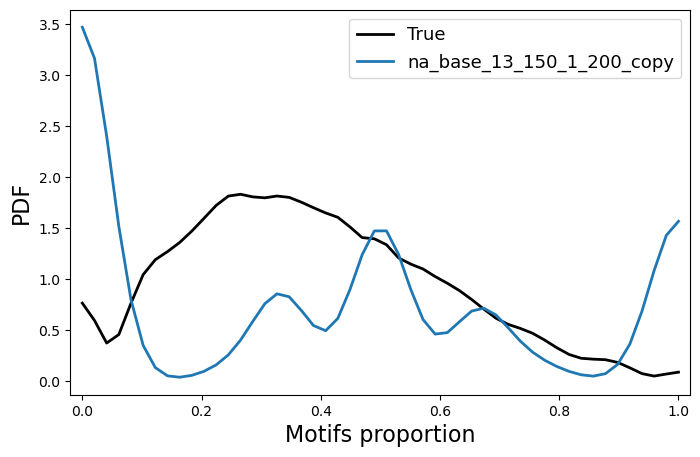

In [268]:
# plot the user distribution of all motifs
plt.figure(figsize=(8, 5))

# plotting
x = np.linspace(0, 1, 50)

# get the user density
user_motifs_proportion = tgt_motifs.groupby("idx").apply(_get_motifs_proportion, include_groups=False).values
Density = stats.gaussian_kde(user_motifs_proportion)
plt.plot(x, Density(x), color="k", linewidth=2, label="True")

for pred_motifs, label in zip(pred_motifs_ls, diff_file_name):
    user_motifs_proportion = pred_motifs.groupby("idx").apply(_get_motifs_proportion, include_groups=False).values
    Density = stats.gaussian_kde(user_motifs_proportion)

    plt.plot(x, Density(x), linewidth=2, label=label)

plt.xlim([-0.02, 1.02])
plt.xlabel("Motifs proportion", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.legend(prop={"size": 13})
plt.show()

Text(0, 0.5, 'Proportion')

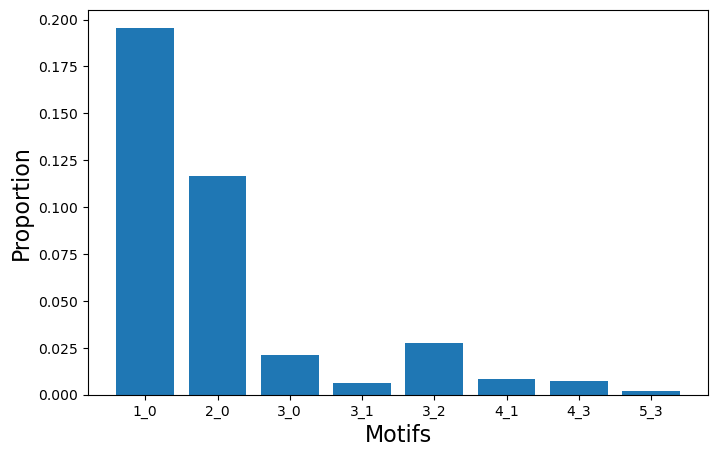

In [274]:
# plot the motifs distribution for all user days
plt.figure(figsize=(8, 5))

# get the proportion of each motif type for y-axis
motifs_frq = (
    tgt_motifs.rename(columns={"size": "uniq_visits"}).dropna(subset="class").groupby(["uniq_visits", "class"], as_index=False).size().reset_index(drop=True)
)
motifs_frq["size"] = motifs_frq["size"] / len(tgt_motifs)
# create unique labels for x-axis
motifs_frq["label"] = (
    motifs_frq["uniq_visits"].astype(int).astype(str) + "_" + motifs_frq["class"].astype(int).astype(str)
)

# plotting
x = np.arange(len(motifs_frq["label"]))
plt.bar(x=x, height=motifs_frq["size"], tick_label=motifs_frq["label"])
plt.xlabel("Motifs", fontsize=16)
plt.ylabel("Proportion", fontsize=16)

# plt.savefig(os.path.join(log_dir, "Mean motifs distribution.png"), bbox_inches="tight", dpi=600)

Text(0, 0.5, 'Proportion')

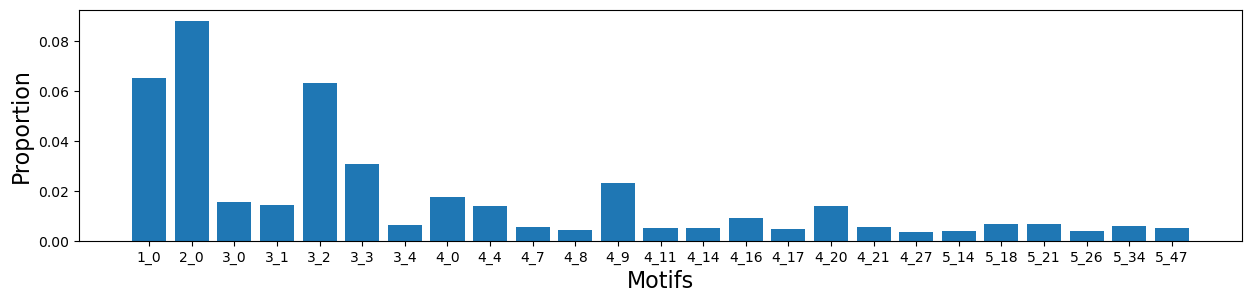

In [280]:
# plot the motifs distribution for all user days
plt.figure(figsize=(15, 3))

# get the proportion of each motif type for y-axis
motifs_frq = (
    pred_motifs_ls[0].rename(columns={"size": "uniq_visits"}).dropna(subset="class").groupby(["uniq_visits", "class"], as_index=False).size().reset_index(drop=True)
)
motifs_frq["size"] = motifs_frq["size"] / len(pred_motifs_ls[0])
# create unique labels for x-axis
motifs_frq["label"] = (
    motifs_frq["uniq_visits"].astype(int).astype(str) + "_" + motifs_frq["class"].astype(int).astype(str)
)

# plotting
x = np.arange(len(motifs_frq["label"]))
plt.bar(x=x, height=motifs_frq["size"], tick_label=motifs_frq["label"])
plt.xlabel("Motifs", fontsize=16)
plt.ylabel("Proportion", fontsize=16)

# plt.savefig(os.path.join(log_dir, "Mean motifs distribution.png"), bbox_inches="tight", dpi=600)

In [277]:
motifs_frq

,uniq_visits,class,size,label
0,1.0,0.0,0.065166,1_0
1,2.0,0.0,0.088319,2_0
2,3.0,0.0,0.015375,3_0
3,3.0,1.0,0.014455,3_1
4,3.0,2.0,0.063173,3_2
5,3.0,3.0,0.030778,3_3
6,3.0,4.0,0.006482,3_4
7,4.0,0.0,0.017549,4_0
8,4.0,4.0,0.013883,4_4
9,4.0,7.0,0.005673,4_7
